In [1]:
import glob, os, sys, re, random
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ete3
from ete3 import PhyloTree
from Bio import SeqIO
import tqdm

In [2]:
def collect_seqs(pattern: str, label: str, genes: list, sp=False):
    directory = "../data/MIDORI2/fasta/"
    file = "MIDORI2_{}_NUC_SP_GB253_{}_BLAST.fasta" if sp else "MIDORI2_{}_NUC_GB253_{}_BLAST.fasta"
    path_to_fasta = directory + file
    seqs = defaultdict(list)
    for gene in tqdm.tqdm(genes):
        inp = path_to_fasta.format(label, gene)
        for rec in SeqIO.parse(inp, "fasta"):
            header = rec.description
            
            if pattern not in header:
                continue

            raw_acc, taxa = header.split("###")
            acc, place = re.match("(\w+\.\d)\.(.+)", raw_acc).groups()
            taxa = taxa.removeprefix("root_1;Eukaryota_2759;")
            species = " ".join(taxa.split(";")[-1].split("_")[:-1])
            rec.id = acc
            rec.description = f"{species} {place} ###{taxa}"
            seqs[gene + "__" + species.replace(" ", "_")].append(rec)
    return seqs


def filter_seqs(recs: list, var_gene_len=0.2, Nshare=0.2):
    assert isinstance(recs, list)
    seq_len_mean = np.median([len(x) for x in recs])
    min_seq_len = seq_len_mean * (1 - var_gene_len)
    max_seq_len = seq_len_mean * (1 + var_gene_len)

    recs_filtered = []
    for rec in recs:
        acgt_share = sum(rec.seq.count(x) for x in "ACGT") / len(rec)
        if min_seq_len < len(rec) < max_seq_len and 1 - acgt_share < Nshare:
            recs_filtered.append(rec)

    return recs_filtered


def filter_seqs_dict(seqs, nseqs_min=10, var_gene_len=0.2, Nshare=0.2):
    assert isinstance(seqs, dict)
    seqs_filtered = dict()
    for gene_species, recs in seqs.items():
        if len(recs) < nseqs_min:
            continue

        recs_filtered = filter_seqs(recs, var_gene_len, Nshare)
        if len(recs_filtered) >= nseqs_min:
            seqs_filtered[gene_species] = recs_filtered
    
    return seqs_filtered

## *Hominidae*

### CYTB

In [3]:
pattern = "Hominidae_9604"
seqs = collect_seqs(pattern, "UNIQ", ['Cytb'])
seqs_filtered = filter_seqs_dict(seqs, 1, 0.05)
print(list(seqs_filtered.keys()))

MAX_SP_NSEQS = 600
cytb_recs = []
for gene_sp, recs in seqs_filtered.items():
    print(gene_sp, len(recs))
    if len(recs) > MAX_SP_NSEQS:
        print(f"Sample {MAX_SP_NSEQS} seqs")
        recs = random.sample(recs, MAX_SP_NSEQS)
    cytb_recs.extend(recs)

cytb_recs_filtered = filter_seqs(cytb_recs, 0.1)

100%|██████████| 1/1 [00:04<00:00,  4.35s/it]

['Cytb__Gorilla_beringei', 'Cytb__Gorilla_gorilla', 'Cytb__Homo_heidelbergensis', 'Cytb__Homo_sapiens', 'Cytb__Pan_paniscus', 'Cytb__Pan_troglodytes', 'Cytb__Pongo_abelii', 'Cytb__Pongo_pygmaeus']
Cytb__Gorilla_beringei 8
Cytb__Gorilla_gorilla 1
Cytb__Homo_heidelbergensis 1
Cytb__Homo_sapiens 5703
Sample 600 seqs
Cytb__Pan_paniscus 19
Cytb__Pan_troglodytes 10
Cytb__Pongo_abelii 10
Cytb__Pongo_pygmaeus 9


In [4]:
gagp_cytb = filter_seqs([x for x in SeqIO.parse("../data/GAGP/genes/CYTB.fna", "fasta")], 0.1)

In [5]:
cytb_collection = []
visited = set()
ndropped = 0
for rec in cytb_recs_filtered + gagp_cytb:
    h = hash(rec.seq)
    if h not in visited:
        cytb_collection.append(rec)
        visited.add(h)
    else:
        ndropped += 1

print(ndropped)
len(cytb_collection), len(cytb_recs_filtered)

45


(665, 628)

In [6]:
SeqIO.write(cytb_collection, "../data/HOMINIDAE/genes/CYTB.fna", "fasta-2line")

665

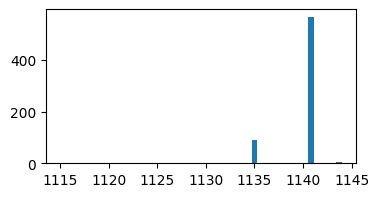

In [7]:
plt.figure(figsize=(4, 2))
plt.hist([len(x) for x in cytb_collection], bins=50);

### ND1

In [8]:
pattern = "Hominidae_9604"
seqs = collect_seqs(pattern, "UNIQ", ['ND1'])
seqs_filtered = filter_seqs_dict(seqs, 1, 0.1)
print(list(seqs_filtered.keys()))

nd1_recs = []
for gene_sp, recs in seqs_filtered.items():
    print(gene_sp, len(recs))
    if len(recs) > MAX_SP_NSEQS:
        print(f"Sample {MAX_SP_NSEQS} seqs")
        recs = random.sample(recs, MAX_SP_NSEQS)
    nd1_recs.extend(recs)

nd1_recs_filtered = filter_seqs(nd1_recs, 0.1)

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

['ND1__Gorilla_beringei', 'ND1__Gorilla_gorilla', 'ND1__Homo_heidelbergensis', 'ND1__Homo_sapiens', 'ND1__Pan_paniscus', 'ND1__Pan_troglodytes', 'ND1__Pongo_abelii', 'ND1__Pongo_pygmaeus']
ND1__Gorilla_beringei 4
ND1__Gorilla_gorilla 6
ND1__Homo_heidelbergensis 1
ND1__Homo_sapiens 3771
Sample 600 seqs
ND1__Pan_paniscus 31
ND1__Pan_troglodytes 96
ND1__Pongo_abelii 3
ND1__Pongo_pygmaeus 4


In [9]:
gagp_nd1 = filter_seqs([x for x in SeqIO.parse("../data/GAGP/genes/ND1.fna", "fasta")], 0.1)

In [10]:
nd1_collection = []
visited = set()
ndropped = 0
for rec in nd1_recs_filtered + gagp_nd1:
    h = hash(rec.seq)
    if h not in visited:
        nd1_collection.append(rec)
        visited.add(h)
    else:
        ndropped += 1

print(ndropped)
len(nd1_collection), len(nd1_recs_filtered)

58


(769, 745)

In [11]:
SeqIO.write(nd1_collection, "../data/HOMINIDAE/genes/ND1.fna", "fasta-2line")

769

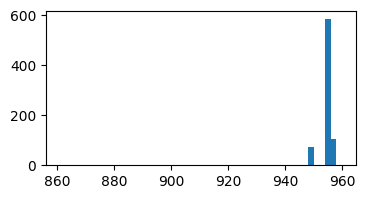

In [12]:
plt.figure(figsize=(4, 2))
plt.hist([len(x) for x in nd1_collection], bins=50);

### COX1

In [13]:
pattern = "Hominidae_9604"
seqs = collect_seqs(pattern, "UNIQ", ['CO1'])
seqs_filtered = filter_seqs_dict(seqs, 1, 0.1)
print(list(seqs_filtered.keys()))

cox1_recs = []
for gene_sp, recs in seqs_filtered.items():
    print(gene_sp, len(recs))
    if len(recs) > MAX_SP_NSEQS:
        print(f"Sample {MAX_SP_NSEQS} seqs")
        recs = random.sample(recs, MAX_SP_NSEQS)
    cox1_recs.extend(recs)

cox1_recs_filtered = filter_seqs(cox1_recs, 0.1)

100%|██████████| 1/1 [00:14<00:00, 14.17s/it]

['CO1__Gorilla_beringei', 'CO1__Gorilla_gorilla', 'CO1__Homo_heidelbergensis', 'CO1__Homo_sapiens', 'CO1__Pan_paniscus', 'CO1__Pan_troglodytes', 'CO1__Pongo_abelii', 'CO1__Pongo_pygmaeus']
CO1__Gorilla_beringei 3
CO1__Gorilla_gorilla 19
CO1__Homo_heidelbergensis 1
CO1__Homo_sapiens 4518
Sample 600 seqs
CO1__Pan_paniscus 17
CO1__Pan_troglodytes 96
CO1__Pongo_abelii 7
CO1__Pongo_pygmaeus 8


In [14]:
gagp_cox1 = filter_seqs([x for x in SeqIO.parse("../data/GAGP/genes/COX1.fna", "fasta")], 0.1)

In [15]:
cox1_collection = []
visited = set()
ndropped = 0
for rec in cox1_recs_filtered + gagp_cox1:
    h = hash(rec.seq)
    if h not in visited:
        cox1_collection.append(rec)
        visited.add(h)
    else:
        ndropped += 1

print(ndropped)
len(cox1_collection), len(cox1_recs_filtered)

48


(655, 621)

In [16]:
SeqIO.write(cox1_collection, "../data/HOMINIDAE/genes/COX1.fna", "fasta-2line")

655

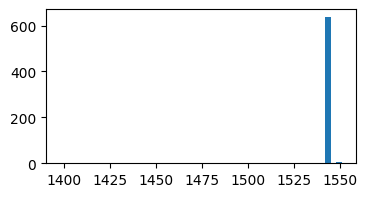

In [17]:
plt.figure(figsize=(4, 2))
plt.hist([len(x) for x in cox1_collection], bins=50);

### Homo sapiens COX1

In [22]:
pattern = "Homo_sapiens"
seqs = collect_seqs(pattern, "UNIQ", ['CO1'])
seqs_filtered = filter_seqs_dict(seqs, 1, 0.05)
print(list(seqs_filtered.keys()))

100%|██████████| 1/1 [00:14<00:00, 14.34s/it]

['CO1__Homo_sapiens']


In [23]:
SeqIO.write(seqs_filtered["CO1__Homo_sapiens"], "../data/exposure_run/human_cox1_raw.fna", "fasta-2line")

4515

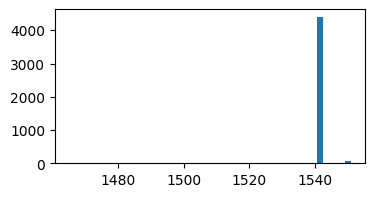

In [24]:
plt.figure(figsize=(4, 2))
plt.hist([len(x) for x in seqs_filtered["CO1__Homo_sapiens"]], bins=50);

## *Mus* genus

### CYTB

In [80]:
pattern = "Mus_10088"
seqs = collect_seqs(pattern, "UNIQ", ['Cytb'])
seqs_filtered = filter_seqs_dict(seqs, 1, 0.05)
print(list(seqs_filtered.keys()))

MAX_SP_NSEQS = 100
cytb_recs = []
for gene_sp, recs in seqs_filtered.items():
    if len(recs) > MAX_SP_NSEQS:
        print(gene_sp)
        recs = random.sample(recs, MAX_SP_NSEQS)
    cytb_recs.extend(recs)

cytb_recs_filtered = filter_seqs(cytb_recs, 0.1)

SeqIO.write(cytb_recs_filtered, "../data/MUS/genes/CYTB.fna", "fasta-2line")

100%|██████████| 1/1 [00:04<00:00,  4.33s/it]

['Cytb__Mus_crociduroides', 'Cytb__Mus_mayori', 'Cytb__Mus_pahari', 'Cytb__Mus_booduga', 'Cytb__Mus_caroli', 'Cytb__Mus_cervicolor', 'Cytb__Mus_cookii', 'Cytb__Mus_cypriacus', 'Cytb__Mus_famulus', 'Cytb__Mus_fragilicauda', 'Cytb__Mus_lepidoides', 'Cytb__Mus_macedonicus', 'Cytb__Mus_musculus', 'Cytb__Mus_nitidulus', 'Cytb__Mus_poschiavinus', 'Cytb__Mus_spicilegus', 'Cytb__Mus_spretus', 'Cytb__Mus_terricolor', 'Cytb__Mus_triton', 'Cytb__Mus_baoulei', 'Cytb__Mus_callewaerti', 'Cytb__Mus_harennensis', 'Cytb__Mus_haussa', 'Cytb__Mus_indutus', 'Cytb__Mus_mahomet', 'Cytb__Mus_mattheyi', 'Cytb__Mus_minutoides', 'Cytb__Mus_musculoides', 'Cytb__Mus_neavei', 'Cytb__Mus_setulosus', 'Cytb__Mus_sorella', 'Cytb__Mus_tenellus', 'Cytb__Mus_fernandoni', 'Cytb__Mus_platythrix', 'Cytb__Mus_saxicola']
Cytb__Mus_musculus
Cytb__Mus_spretus


445

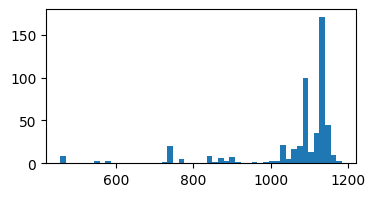

In [78]:
plt.figure(figsize=(4, 2))
plt.hist([len(x) for x in cytb_recs], bins=50);

### ND1

In [75]:
pattern = "Mus_10088"
seqs = collect_seqs(pattern, "UNIQ", ['ND1'])
seqs_filtered = filter_seqs_dict(seqs, 1, 0.1)
print(list(seqs_filtered.keys()))

MAX_SP_NSEQS = 100
cytb_recs = []
for gene_sp, recs in seqs_filtered.items():
    if len(recs) > MAX_SP_NSEQS:
        print(gene_sp)
        recs = random.sample(recs, MAX_SP_NSEQS)
    cytb_recs.extend(recs)

cytb_recs_filtered = filter_seqs(cytb_recs, 0.1)

SeqIO.write(cytb_recs_filtered, "../data/MUS/genes/ND1.fna", "fasta-2line")

100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

['ND1__Mus_pahari', 'ND1__Mus_caroli', 'ND1__Mus_cervicolor', 'ND1__Mus_cookii', 'ND1__Mus_famulus', 'ND1__Mus_fragilicauda', 'ND1__Mus_musculus', 'ND1__Mus_spretus', 'ND1__Mus_terricolor', 'ND1__Mus_baoulei', 'ND1__Mus_saxicola']


106

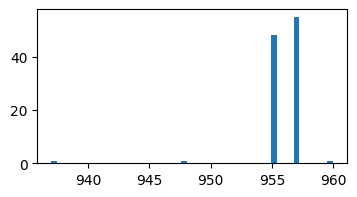

In [76]:
plt.figure(figsize=(4, 2))
plt.hist([len(x) for x in cytb_recs], bins=50);

### COX1

In [9]:
pattern = "Mus_10088"
seqs = collect_seqs(pattern, "UNIQ", ['CO1'])
seqs_filtered = filter_seqs_dict(seqs, 1, 0.1)
print(list(seqs_filtered.keys()))

MAX_SP_NSEQS = 100
cytb_recs = []
for gene_sp, recs in seqs_filtered.items():
    if len(recs) > MAX_SP_NSEQS:
        print(gene_sp)
        recs = random.sample(recs, MAX_SP_NSEQS)
    cytb_recs.extend(recs)

cytb_recs_filtered = filter_seqs(cytb_recs, 0.1)

SeqIO.write(cytb_recs_filtered, "../data/MUS/genes/COX1.fna", "fasta-2line")

100%|██████████| 1/1 [00:15<00:00, 15.46s/it]

['CO1__Mus_pahari', 'CO1__Mus_caroli', 'CO1__Mus_cookii', 'CO1__Mus_famulus', 'CO1__Mus_fragilicauda', 'CO1__Mus_macedonicus', 'CO1__Mus_musculus_domesticus_x_Mus_spretus', 'CO1__Mus_musculus', 'CO1__Mus_spicilegus', 'CO1__Mus_spretus', 'CO1__Mus_terricolor', 'CO1__Mus_baoulei', 'CO1__Mus_minutoides', 'CO1__Mus_setulosus', 'CO1__Mus_sorella', 'CO1__Mus_saxicola']
CO1__Mus_musculus


114

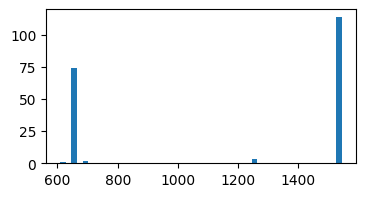

In [10]:
plt.figure(figsize=(4, 2))
plt.hist([len(x) for x in cytb_recs], bins=50);

## *Mus musculus* & *Mus spretus*

In [44]:
genes = ['Cytb', 'ND1']
pattern1 = "Mus_musculus"
seqs1 = collect_seqs(pattern1, "UNIQ", genes)
seqs1_filtered = filter_seqs(seqs1, 1)

pattern2 = "Mus_spretus"
seqs2 = collect_seqs(pattern2, "UNIQ", genes)
seqs2_filtered = filter_seqs(seqs2, 1)

100%|██████████| 2/2 [00:05<00:00,  2.53s/it]


In [55]:
seqs2_filtered["ND1__Mus_spretus"]

[SeqRecord(seq=Seq('GTGTTCTTTATCAACATTTTAACACTCCTCCTACCTATCCTAATCGCTATGGCT...TAT'), id='MW209725.1', name='MW209725.1.2746.3700###root_1;Eukaryota_2759;Chordata_7711;Mammalia_40674;Rodentia_9989;Muridae_10066;Mus_10088;Mus_spretus_10096', description='Mus spretus 2746.3700 ###Chordata_7711;Mammalia_40674;Rodentia_9989;Muridae_10066;Mus_10088;Mus_spretus_10096', dbxrefs=[]),
 SeqRecord(seq=Seq('GTGTTCTTTATCAACATTTTAACACTCCTCCTACCTATCCTAATCGCTATGGCT...TAT'), id='KY018921.1', name='KY018921.1.2749.3703###root_1;Eukaryota_2759;Chordata_7711;Mammalia_40674;Rodentia_9989;Muridae_10066;Mus_10088;Mus_spretus_10096', description='Mus spretus 2749.3703 ###Chordata_7711;Mammalia_40674;Rodentia_9989;Muridae_10066;Mus_10088;Mus_spretus_10096', dbxrefs=[])]

In [53]:
seqs2_filtered.keys()

dict_keys(['Cytb__Mus_spretus', 'ND1__Mus_spretus'])

In [56]:
nd1 = []
g = "ND1"
for p, s in zip([pattern1, pattern2], [seqs1_filtered, seqs2_filtered]):
    for r in s[g+ "__" + p]:
        nd1.append(r)

cytb = []
g = "Cytb"
for p, s in zip([pattern1, pattern2], [seqs1_filtered, seqs2_filtered]):
    for r in s[g+ "__" + p]:
        cytb.append(r)

In [60]:
print(f"nseqs = {len(cytb)}")
print(f"nseqs = {len(nd1)}")

nseqs = 769
nseqs = 93


In [61]:
SeqIO.write(nd1, "../data/exposure/mus_nd1/seqs.fasta", "fasta-2line")
SeqIO.write(cytb, "../data/exposure/mus_cytb/seqs.fasta", "fasta-2line")

769

## *Arthropoda*

In [ ]:
genes = ['A6', 'A8', 'CO1', 'CO2', 'CO3', 'Cytb', 'ND1', 'ND2', 'ND3', 'ND4', 'ND4L', 'ND5', 'ND6']
phylum = "Arthropoda"
seqs_arth = collect_seqs(phylum, "UNIQ", genes)
len(seqs_arth)

In [26]:
seqs_arth_filtered = filter_seqs(seqs_arth)
print(f"nseqs = {len(seqs_arth_filtered)}, nspecies: {len(set([x.split('__')[1] for x in seqs_arth_filtered.keys()]))}", end="\n\n")
print(pd.Series(Counter([x.split("__")[0] for x in seqs_arth_filtered.keys()])))

nseqs = 19172, nspecies: 17676

A6         65
A8         24
CO1     17116
CO2       723
CO3        73
Cytb      549
ND1       151
ND2        83
ND3        28
ND4        82
ND4L       22
ND5       211
ND6        45
dtype: int64


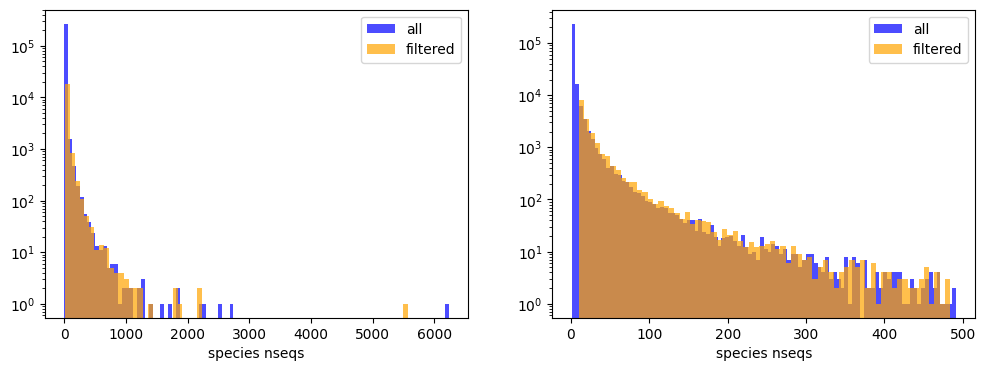

In [29]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist([len(v) for v in seqs_arth.values()], bins=100, alpha=0.7, label="all", color="blue")
plt.hist([len(v) for v in seqs_arth_filtered.values()], bins=70, alpha=0.7, label="filtered", color="orange")
plt.yscale("log")
plt.xlabel("species nseqs")
plt.legend()

plt.subplot(122)
plt.hist([len(v) for v in seqs_arth.values() if len(v) < 500], bins=100, alpha=0.7, label="all", color="blue")
plt.hist([len(v) for v in seqs_arth_filtered.values() if len(v) < 500], bins=70, alpha=0.7, label="filtered", color="orange")
plt.yscale("log")
plt.xlabel("species nseqs")
plt.legend()

plt.show()

### Prepare dataset for CO1 alignment (outgrp selection)

In [20]:
arth_aln = collect_seqs(phylum, "LONGEST", ["CO1"])

100%|██████████| 1/1 [00:03<00:00,  3.12s/it]


In [32]:
print(len(set([x.split("__")[1] for x in seqs_arth_filtered.keys()]).difference([x.split("__")[1] for x in arth_aln.keys()])), "species without CO1 seq")

136 species without CO1 seq


## Chordata

In [3]:
genes = ['A6', 'A8', 'CO1', 'CO2', 'CO3', 'Cytb', 'ND1', 'ND2', 'ND3', 'ND4', 'ND4L', 'ND5', 'ND6']
phylum = "Chordata"
seqs_uniq = collect_seqs(phylum, "UNIQ", genes)
len(seqs_uniq)

100%|██████████| 13/13 [00:38<00:00,  2.97s/it]


192350

In [4]:
seqs_uniq_filtered = filter_seqs_dict(seqs_uniq)
print(f"ngenes = {len(seqs_uniq_filtered)}, nspecies: {len(set([x.split('__')[1] for x in seqs_uniq_filtered.keys()]))}", end="\n\n")
print(pd.Series(Counter([x.split("__")[0] for x in seqs_uniq_filtered.keys()])))

ngenes = 15496, nspecies: 10163

A6       501
A8       185
CO1     5447
CO2      200
CO3      207
Cytb    4963
ND1      389
ND2     1902
ND3      250
ND4      831
ND4L     119
ND5      306
ND6      196
dtype: int64


In [5]:
co1_sp = [x.split("__")[1] for x in seqs_uniq_filtered.keys() if x.startswith("CO1")]
cytb_sp = [x.split("__")[1] for x in seqs_uniq_filtered.keys() if x.startswith("Cytb")]
len(set(co1_sp).intersection(cytb_sp))

1750

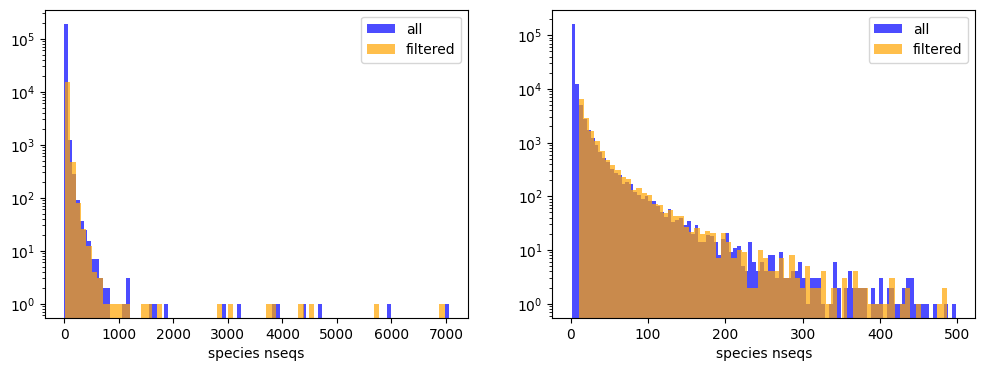

In [6]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist([len(v) for v in seqs_uniq.values()], bins=100, alpha=0.7, label="all", color="blue")
plt.hist([len(v) for v in seqs_uniq_filtered.values()], bins=70, alpha=0.7, label="filtered", color="orange")
plt.yscale("log")
plt.xlabel("species nseqs")
plt.legend()

plt.subplot(122)
plt.hist([len(v) for v in seqs_uniq.values() if len(v) < 500], bins=100, alpha=0.7, label="all", color="blue")
plt.hist([len(v) for v in seqs_uniq_filtered.values() if len(v) < 500], bins=70, alpha=0.7, label="filtered", color="orange")
plt.yscale("log")
plt.xlabel("species nseqs")
plt.legend()

plt.show()

### Check genus-wise species distribution

In [7]:
genes = ['A6', 'A8', 'CO1', 'CO2', 'CO3', 'Cytb', 'ND1', 'ND2', 'ND3', 'ND4', 'ND4L', 'ND5', 'ND6']
phylum = "Chordata"
seqs_longest = collect_seqs(phylum, "LONGEST", genes, sp=True)

100%|██████████| 13/13 [00:15<00:00,  1.19s/it]


In [8]:
seqs_longest["A6__Branchiostoma_belcheri"][0].description

'Branchiostoma belcheri 8821.9504 ###Chordata_7711;Leptocardii_2682552;Amphioxiformes_2682553;Branchiostomatidae_7736;Branchiostoma_7737;Branchiostoma_belcheri_7741'

In [9]:
data_taxa = []
for gene_sp, seqs in seqs_uniq_filtered.items():
    raw_taxonomy = seqs[0].description.split("###")[1]
    phyl, clss, order, fam, genus, sp = ["_".join(x.split("_")[:-1]) for x in raw_taxonomy.split(";")]
    data_taxa.append(dict(gene=gene_sp.split('__')[0], clss=clss, order=order, fam=fam, genus=genus, species=sp, nseqs=len(seqs)))
genes_taxa_uniq = pd.DataFrame(data_taxa)

data_taxa = []
for gene_sp, seqs in seqs_longest.items():
    raw_taxonomy = seqs[0].description.split("###")[1]
    phyl, clss, order, fam, genus, sp = ["_".join(x.split("_")[:-1]) for x in raw_taxonomy.split(";")]
    data_taxa.append(dict(gene=gene_sp.split('__')[0], clss=clss, order=order, fam=fam, genus=genus, species=sp))
genes_taxa_longest = pd.DataFrame(data_taxa)
del data_taxa

In [10]:
genes_taxa_uniq

,gene,clss,order,fam,genus,species,nseqs
0,A6,Leptocardii,Amphioxiformes,Branchiostomatidae,Branchiostoma,Branchiostoma_belcheri,15
1,A6,Leptocardii,Amphioxiformes,Branchiostomatidae,Branchiostoma,Branchiostoma_floridae,20
2,A6,Leptocardii,Amphioxiformes,Branchiostomatidae,Branchiostoma,Branchiostoma_lanceolatum,10
3,A6,Hyperoartia,Petromyzontiformes,Petromyzontidae,Lampetra,Lampetra_fluviatilis,37
4,A6,Hyperoartia,Petromyzontiformes,Petromyzontidae,Lampetra,Lampetra_planeri,28
...,...,...,...,...,...,...,...
15491,ND6,Amphibia,Caudata,Cryptobranchidae,Andrias,Andrias_davidianus,25
15492,ND6,Amphibia,Caudata,Hynobiidae,Pachyhynobius,Pachyhynobius_shangchengensis,22
15493,ND6,Amphibia,Caudata,Hynobiidae,Salamandrella,Salamandrella_keyserlingii,15
15494,ND6,Amphibia,Caudata,Plethodontidae,Eurycea,Eurycea_spelaea,10


In [11]:
nonstandart_names = genes_taxa_uniq[genes_taxa_uniq.species.str.count("_") > 1].species.str.split("_")\
    .apply(lambda x: x[:2]).str.join("_").unique()

genes_taxa_uniq[genes_taxa_uniq.species.isin(nonstandart_names)].shape
# So, drop these broken species names

(54, 7)

In [12]:
genes_taxa_uniq = genes_taxa_uniq[genes_taxa_uniq.species.str.count("_") == 1]
genes_taxa_uniq.shape

(15463, 7)

In [13]:
(genes_taxa_longest[genes_taxa_longest.genus.isin(genes_taxa_uniq.genus)].groupby("genus").species.unique().apply(len) == 1).sum()

590

### Derive TimeTree

#### Rename broken leaf names

In [15]:
tt_species = pd.read_csv("../data/chordata/timetree_species.txt", header=None, sep="\t", names=["species"])
tt_species["new"] = tt_species.species
tt_species.loc[tt_species.new.str.contains("[^a-zA-Z_]"), "new"] = "None"
tt_species.to_csv("../data/chordata/species_mapper.txt", header=None, index=None, sep="\t")

In [16]:
!nw_rename ../data/chordata/chordates_species_total.txt ../data/chordata/species_mapper.txt > ../data/chordata/chordates_species_total_filtered.nwk

#### Read trees

In [14]:
timetree_genus = PhyloTree("../data/chordata/chordates_genus.nwk", format=1)
timetree_species = PhyloTree("../data/chordata/chordates_species_total_filtered.nwk", format=1)

timetree_species.search_nodes(name="Tenebrosternarchus_preto")[0].delete() # have dublicat
timetree_species.describe()

Number of leaf nodes:	38620
Total number of nodes:	77234
Rooted:	Yes
Most distant node:	Sitta_whiteheadi
Max. distance:	588.455150


In [15]:
timetree_species.prune(set(genes_taxa_longest.species.unique()).intersection(timetree_species.get_leaf_names()), True)
timetree_species.describe()

Number of leaf nodes:	32481
Total number of nodes:	64961
Rooted:	Yes
Most distant node:	Myioborus_cardonai
Max. distance:	588.455150


In [48]:
timetree_species.write(outfile="../data/chordata/chordates_species_total_filtered_twice.nwk", format=1)

In [99]:
hs = timetree_genus.search_nodes(name="Homo")[0]
print(hs.up.up.up.get_ascii(attributes=["name", "dist"]))


                            /-Gorilla, 8.6
                /'17045', 6.6
               |           |            /-Homo, 6.4
-'17044', 4.25714           \'17047', 2.2
               |                        \-Pan, 6.4
               |
                \-Pongo, 15.2


In [70]:
def get_closest_leaf(leaf):
    d = 0
    for x in leaf.up.children:
        if x.name != leaf.name:
            d += x.dist
            leaf_closest, d2 = x.get_closest_leaf()
            d += d2
            break
    return leaf_closest, d


def get_closest_leaves(leaf):
    colsest = []
    i = 0
    for x in leaf.up.get_leaves():
        if i == 100:
            break
        if x.name != leaf.name:
            d = leaf.get_distance(x)
            colsest.append({"leaf1":leaf.name, "leaf2":x.name, "d": d})
        i += 1
    return colsest

In [71]:
data=[]
for leaf in tqdm.tqdm(timetree_species.iter_leaves()):
    a = get_closest_leaves(leaf)
    data.extend(a)
    
df_closest = pd.DataFrame(data)
del data

32481it [00:08, 3658.74it/s]


In [90]:
df_closest.shape

(126531, 11)

In [73]:
df_closest["common_genus"] = df_closest.leaf1.apply(lambda x: x.split("_")[0]) == df_closest.leaf2.apply(lambda x: x.split("_")[0])

In [75]:
df_closest = df_closest.merge(genes_taxa_longest[["order", "fam", "species"]].drop_duplicates(), right_on="species", left_on="leaf1")\
    .drop("species", axis=1).rename(columns={"order":"leaf1_order", "fam":"leaf1_fammily"})\
        .merge(genes_taxa_longest[["order", "fam", "species"]].drop_duplicates(), right_on="species", left_on="leaf2")\
            .drop("species", axis=1).rename(columns={"order":"leaf2_order", "fam":"leaf2_fammily"})
df_closest.head(2)

,leaf1,leaf2,d,common_genus,leaf1_order,leaf1_fammily,leaf2_order,leaf2_fammily
0,Asymmetron_lucayanum,Asymmetron_inferum,133.71624,True,Amphioxiformes,Branchiostomatidae,Amphioxiformes,Branchiostomatidae
1,Asymmetron_inferum,Asymmetron_lucayanum,133.71624,True,Amphioxiformes,Branchiostomatidae,Amphioxiformes,Branchiostomatidae


In [76]:
df_closest["common_family"] = df_closest.leaf1_fammily == df_closest.leaf2_fammily
df_closest["common_order"] = df_closest.leaf1_order == df_closest.leaf2_order

In [80]:
df_closest["commonnes"] = df_closest.common_genus.astype(np.int8) + df_closest.common_family + df_closest.common_order

In [82]:
df_closest.groupby("commonnes").d.mean()

commonnes
0    233.853977
1    101.037337
2     58.984499
3     28.794149
Name: d, dtype: float64

<AxesSubplot:xlabel='d', ylabel='Density'>

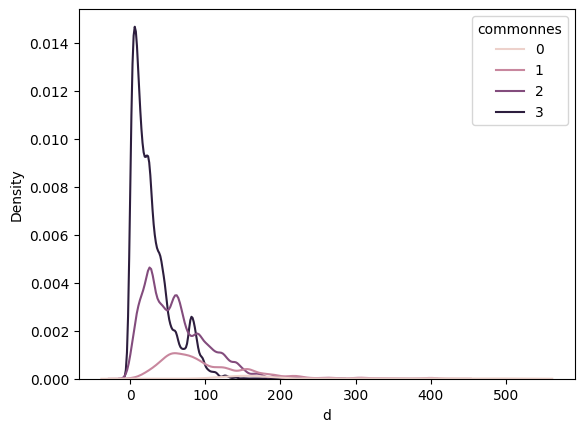

In [87]:
sns.kdeplot(data=df_closest[df_closest.d < 500], x='d', hue="commonnes")

In [192]:
# all paird in the table will be from single family
# leaf1 in uniq, leaf2 in longest
df_closest_filtered = df_closest[df_closest.common_family].iloc[:, [0,1,2,3, 8]]
# df_closest_filtered = df_closest_filtered[(df_closest_filtered.leaf1.isin(genes_taxa_uniq.species)) & (df_closest_filtered.leaf2.isin(genes_taxa_longest.species))]
df_closest_filtered.shape

(111086, 5)

In [193]:
df_closest_filtered

,leaf1,leaf2,d,common_genus,common_family
0,Asymmetron_lucayanum,Asymmetron_inferum,133.71624,True,True
1,Asymmetron_inferum,Asymmetron_lucayanum,133.71624,True,True
2,Epigonichthys_maldivensis,Epigonichthys_cultellus,55.27994,True,True
3,Epigonichthys_cultellus,Epigonichthys_maldivensis,55.27994,True,True
4,Branchiostoma_japonicum,Branchiostoma_belcheri,43.85038,True,True
...,...,...,...,...,...
126520,Botryllus_schlosseri,Polyandrocarpa_anguinea,333.00600,False,True
126523,Styela_plicata,Dendrodoa_grossularia,393.82300,False,True
126524,Polyandrocarpa_anguinea,Dendrodoa_grossularia,304.17200,False,True
126525,Botryllus_schlosseri,Dendrodoa_grossularia,333.00600,False,True


### search_closest_in_longest_list

In [112]:
def search_closest_in_longest_list(row:pd.Series):
    df_gene = genes_taxa_longest[(genes_taxa_longest.gene==row.gene) & (genes_taxa_longest.species != row.species)]
    df_genus = df_gene[df_gene.genus == row.genus]
    if len(df_genus):
        return df_genus.species.to_list()
    df_fam = df_gene[df_gene.fam == row.fam]
    if len(df_fam):
        return df_fam.species.to_list()
    return []

In [114]:
genes_taxa_uniq.iloc[0], search_closest_in_longest_list(genes_taxa_uniq.iloc[0])

(gene                           A6
 clss                  Leptocardii
 order              Amphioxiformes
 fam            Branchiostomatidae
 genus               Branchiostoma
 species    Branchiostoma_belcheri
 nseqs                          15
 Name: 0, dtype: object,
 ['Branchiostoma_floridae',
  'Branchiostoma_japonicum',
  'Branchiostoma_lanceolatum'])

In [ ]:
# runtime: 15min
# save 
genes_taxa_uniq["closest"] = genes_taxa_uniq.apply(search_closest_in_longest_list, axis=1)
genes_taxa_uniq.to_csv("../data/chordata/raw_uniq_closest.csv", index=False)

### merge taxa closest (family-specific) and timetree 

In [228]:
uniq_closest = genes_taxa_uniq.explode("closest").drop(["clss", "order", "fam", "genus"], axis=1).dropna()\
    .merge(df_closest.iloc[:, [0,1,2,3]], "left", left_on=["species", "closest"], right_on=["leaf1", "leaf2"]).drop(["leaf1", "leaf2"], axis=1)

uniq_closest["common_genus"] = uniq_closest.species.apply(lambda x: x.split("_")[0]) == uniq_closest.closest.apply(lambda x: x.split("_")[0])

In [229]:
uniq_closest.head()

,gene,species,nseqs,closest,d,common_genus
0,A6,Branchiostoma_belcheri,15,Branchiostoma_floridae,NaN,True
1,A6,Branchiostoma_belcheri,15,Branchiostoma_japonicum,43.85038,True
2,A6,Branchiostoma_belcheri,15,Branchiostoma_lanceolatum,NaN,True
3,A6,Branchiostoma_floridae,20,Branchiostoma_belcheri,NaN,True
4,A6,Branchiostoma_floridae,20,Branchiostoma_japonicum,NaN,True


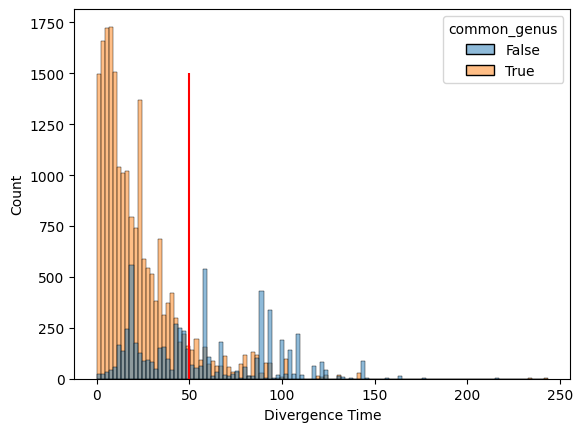

In [230]:
ax = sns.histplot(data=uniq_closest, x="d", hue="common_genus").set_xlabel("Divergence Time");
plt.vlines([50], 0, 1500, 'r');

**Divergence time CUTOFF = 50 mln years**

In [231]:
DIFERGENCE_CUTOFF = 50

In [232]:
uniq_closest["d"] = uniq_closest.d.fillna(-1)

In [302]:
uniq_closest_filtered = uniq_closest[
    (uniq_closest.d < DIFERGENCE_CUTOFF) &
    (uniq_closest.closest.str.count("_") == 1) &
    (
        (uniq_closest.common_genus) | 
        ((~uniq_closest.common_genus) & (uniq_closest.d > 0))
    )
]

assert uniq_closest_filtered[uniq_closest_filtered.common_genus].d.max() < DIFERGENCE_CUTOFF
assert uniq_closest_filtered[~uniq_closest_filtered.common_genus].d.min() > 0

In [303]:
uniq_closest_filtered.shape

(278417, 6)

In [304]:
uniq_closest_filtered.to_csv("../data/chordata/closest_full.csv", index=False)

In [305]:
uniq_closest_filtered.groupby(["gene", "species"])\
    .apply(lambda gr: gr[gr.d == gr.d.max()].sample())\
        .to_csv("../data/chordata/closest_sample.csv", index=False)

## Write species-fasta files

In [306]:
closest_sample = pd.read_csv("../data/chordata/closest_sample.csv")
print(closest_sample.shape)
closest_sample.head()

(14551, 6)


,gene,species,nseqs,closest,d,common_genus
0,A6,Acanthurus_nigricans,25,Acanthurus_triostegus,-1.00000,True
1,A6,Acanthurus_triostegus,58,Acanthurus_leucosternon,-1.00000,True
2,A6,Adelomyia_melanogenys,81,Aglaiocercus_kingii,17.19276,False
3,A6,Agkistrodon_contortrix,26,Agkistrodon_taylori,19.09636,True
4,A6,Agkistrodon_piscivorus,18,Agkistrodon_taylori,14.24572,True


In [316]:
for i, row in closest_sample.iterrows():
    sp_recs = seqs_uniq_filtered[row.gene + "__" + row.species]
    cl_rec = seqs_longest[row.gene + "__" + row.closest][0]
    cl_rec.id = "OUTGRP"
    cl_rec.name = "OUTGRP"
    cl_rec.description = "OUTGRP"
    sp_recs.append(cl_rec)
    SeqIO.write(sp_recs, f"../data/chordata/dataset/{row.gene}__{row.species}.fasta", "fasta-2line")